In [1]:
from sparc import load_model
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import librosa

/Users/ashish/anaconda3/envs/avhubert/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scipy.signal as signal

def modify_noise_len(clean_audio, noise):
    # Truncate or loop noise to match length of clean audio
    clean_len = clean_audio.shape[0]
    noise_len = noise.shape[0]
    if clean_len < noise_len:
        # TODO: could also get a random segment of the noise
        noise = noise[:clean_len]
    elif clean_len > noise_len:
        n_loops = clean_len // noise_len + 1
        # Apply Tukey window to avoid popping
        tukey = torch.from_numpy(signal.windows.tukey(noise_len))
        noise = noise * tukey
        noise = noise.tile((n_loops,))[:clean_len]
        
    return noise

In [3]:
# Augment data
clean_path = "./data/val_data/video/_6bNvy6IFAs_0.mp4"
noise_path = "./data/val_data/noise/noise-free-sound-0000.wav"   # noise condition may be too easy
sr = 16000
snr_db = 3  # TODO: use list of a range of SNRs

clean_audio, _ = librosa.load(clean_path, sr=sr, mono=True)
noise, _ = librosa.load(noise_path, sr=sr, mono=True)
noise = modify_noise_len(clean_audio, noise)

clean_audio = torch.from_numpy(clean_audio.reshape((1, clean_audio.shape[0])))
noise = torch.from_numpy(noise.reshape((1, noise.shape[0])))
noisy_audio = torchaudio.functional.add_noise(clean_audio, noise, torch.Tensor([snr_db]))

clean_audio = clean_audio.numpy().flatten()
noisy_audio = noisy_audio.numpy().flatten()

ipd.Audio(noisy_audio, rate=sr)

/var/folders/qk/638_x33s14n5hnwxcp1kdyk00000gn/T/ipykernel_34378/700194172.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  clean_audio, _ = librosa.load(clean_path, sr=sr, mono=True)
/Users/ashish/anaconda3/envs/avhubert/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [6]:
!pip install penn

  Using cached penn-0.0.14-py3-none-any.whl.metadata (12 kB)
  Using cached torchutil-0.0.14-py3-none-any.whl.metadata (24 kB)
  Using cached yapecs-0.0.8-py3-none-any.whl.metadata (10 kB)
  Using cached apprise-1.9.0-py3-none-any.whl.metadata (51 kB)
  Using cached tensorboard-2.14.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached google_auth-2.36.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.6-py3-none-any.whl.metadata (3.7 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyasn1_modules-0.4.1-py3-none-an

In [7]:
coder = load_model("multi", device= "cpu", use_penn=False)
clean_code = coder.encode(clean_audio)
noisy_code = coder.encode(noisy_audio)

Using PENN for pitch tracking.


AttributeError: 'NoneType' object has no attribute 'from_audio'

In [7]:
import matplotlib
color_code = {"UL":matplotlib.colors.to_rgb("#EE3A5B"),
              "LL":matplotlib.colors.to_rgb("#FFD155"),
              "LI":matplotlib.colors.to_rgb("#959595"),
              "TT":matplotlib.colors.to_rgb("#43B962"),
              "TB":matplotlib.colors.to_rgb("#C44B9F"),
              "TD":matplotlib.colors.to_rgb("#0093B7"),
              "Loudness":matplotlib.colors.to_rgb("#FB754D"),
              "Pitch":matplotlib.colors.to_rgb("#FB754D"),}

def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2):
    yticks=[]
    ytick_labels=[]
    labels = ["UL","LL", "LI", "TT", "TB", "TD"]
    chidxs = []
    HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    channel_label = HPRC_channel_label
    for l in labels:
        chidxs.append(HPRC_channel_label.index(l+"X"))
        chidxs.append(HPRC_channel_label.index(l+"Y"))


    for i,ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        else:
            art_name= ch_label
            if color is None:
                color = color_code[art_name]
            ax.plot(art[:,ch_i]-gap*i,color=color,alpha=alpha,lw=lw)
        yticks.append(-gap*i)
    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    xticks= np.arange(0,len(art),50)
    xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_xlim(0,len(art))
    return yticks

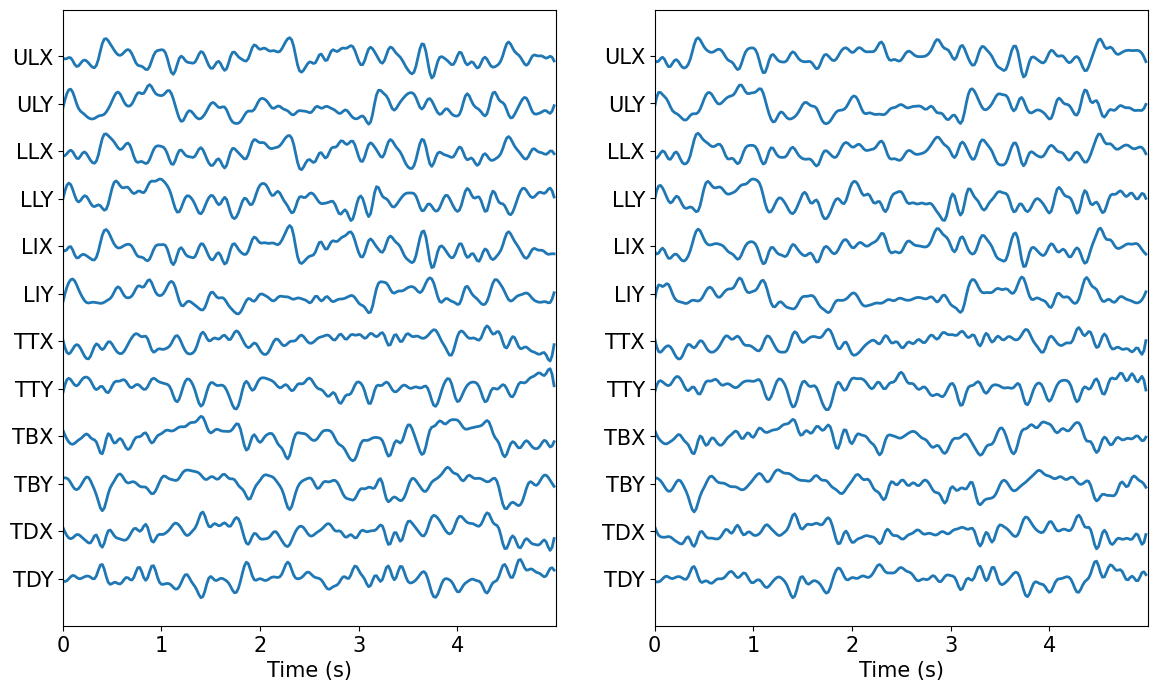

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
plot_art(ax[0], clean_code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plot_art(ax[1], noisy_code['ema'][:400], color='C0', gap=6, alpha=1, lw=2)
plt.show()

In [9]:
clean_resynth = coder.decode(**clean_code)
noisy_resynth = coder.decode(**noisy_code)

ipd.display(ipd.Audio(clean_resynth, rate=sr))
ipd.display(ipd.Audio(noisy_resynth, rate=sr))

In [11]:
import os
import time
import logging
import torch
import librosa
import torchaudio
import scipy.signal as signal
from sparc import load_model
import numpy as np
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s',
    handlers=[
        logging.FileHandler('noise_evaluation.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def modify_noise_len(clean_audio, noise):
    clean_len = clean_audio.shape[0]
    noise_len = noise.shape[0]
    
    if clean_len < noise_len:
        noise = noise[:clean_len]
    elif clean_len > noise_len:
        n_loops = clean_len // noise_len + 1
        tukey = torch.from_numpy(signal.windows.tukey(noise_len))
        noise = noise * tukey
        noise = noise.tile((n_loops,))[:clean_len]
    
    return noise

def process_noise_evaluation(clean_paths, noise_paths, snr_levels, sr=16000):
    logger.info(f"Starting noise evaluation with {len(clean_paths)} clean audio files")
    logger.info(f"Noise files: {[os.path.basename(np.path) for np.path in noise_paths]}")
    logger.info(f"SNR levels: {snr_levels}")
    
    start_time = time.time()
    coder = load_model("multi", device="cpu", use_penn=True)
    
    results = {}
    total_iterations = len(clean_paths) * len(noise_paths) * len(snr_levels)
    processed_iterations = 0
    
    for clean_idx, clean_path in enumerate(clean_paths, 1):
        logger.info(f"Processing clean audio file {clean_idx}/{len(clean_paths)}: {os.path.basename(clean_path)}")
        
        clean_audio, _ = librosa.load(clean_path, sr=sr, mono=True)
        clean_audio = torch.from_numpy(clean_audio.reshape((1, clean_audio.shape[0])))
        print(clean_audio.numpy().flatten())
        clean_code = coder.encode(clean_audio.numpy().flatten())
        
        clean_file_results = {}
        for noise_idx, noise_path in enumerate(noise_paths, 1):
            logger.info(f"  Applying noise file {noise_idx}/{len(noise_paths)}: {os.path.basename(noise_path)}")
            
            noise, _ = librosa.load(noise_path, sr=sr, mono=True)
            adjusted_noise = modify_noise_len(clean_audio.numpy().flatten(), noise)
            noise_tensor = torch.from_numpy(adjusted_noise.reshape((1, adjusted_noise.shape[0])))
            
            noise_results = {}
            for snr_idx, snr in enumerate(snr_levels, 1):
                processed_iterations += 1
                progress_percent = (processed_iterations / total_iterations) * 100
                
                logger.info(f"    Processing SNR {snr} dB (Level {snr_idx}/{len(snr_levels)})")
                
                noisy_audio = torchaudio.functional.add_noise(clean_audio, noise_tensor, torch.Tensor([snr]))
                noisy_code = coder.encode(noisy_audio.numpy().flatten())
                
                loss = torch.nn.functional.mse_loss(clean_code, noisy_code)
                noise_results[snr] = loss.item()
                
                logger.info(f"    MSE Loss: {loss.item():.6f}")
                logger.info(f"    Overall Progress: {progress_percent:.2f}%")
            
            clean_file_results[os.path.basename(noise_path)] = noise_results
        
        results[os.path.basename(clean_path)] = clean_file_results
    
    end_time = time.time()
    total_duration = end_time - start_time
    logger.info(f"Evaluation complete. Total processing time: {total_duration:.2f} seconds")
    logger.info(f"Processed {total_iterations} iterations")
    
    return results

def visualize_results(results):
    plt.figure(figsize=(15, 10))
    
    num_clean_files = len(results)
    rows = (num_clean_files + 1) // 2
    
    for idx, (clean_file, noise_results) in enumerate(results.items(), 1):
        plt.subplot(rows, 2, idx)
        
        for noise_type, snr_losses in noise_results.items():
            snrs = list(snr_losses.keys())
            losses = list(snr_losses.values())
            plt.plot(snrs, losses, marker='o', label=noise_type)
        
        plt.title(f'Clean File: {clean_file}')
        plt.xlabel('Signal-to-Noise Ratio (dB)')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('noise_evaluation_plot.png')
    logger.info("Results visualization saved to noise_evaluation_plot.png")
    plt.show()

def main():
    clean_dir = "./data/val_data/video/"
    noise_dir = "./data/train_data/noise/"
    
    clean_paths = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir)]
    noise_paths = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) 
                   if f.endswith('.wav')]
    snr_levels = [-3, 0, 3, 5, 10]
    
    logger.info("Starting Noise Evaluation Script")
    logger.info(f"Clean audio files found: {len(clean_paths)}")
    logger.info(f"Noise files found: {len(noise_paths)}")
    
    results = process_noise_evaluation(clean_paths, noise_paths, snr_levels)
    
    visualize_results(results)

if __name__ == "__main__":
    main()

/Users/ashish/Desktop/Fall2024/AudioSignal/av_hubert/avhubert/sparc/sparc.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt)


Using PENN for pitch tracking.


/Users/ashish/anaconda3/envs/avhubert/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/var/folders/qk/638_x33s14n5hnwxcp1kdyk00000gn/T/ipykernel_67951/1265035528.py:52: UserWarning: PySoundFile failed. Trying audioread instead.
  clean_audio, _ = librosa.load(clean_path, sr=sr, mono=True)
/Users/ashish/anaconda3/envs/avhubert/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[0.00122399 0.00731033 0.02283401 ... 0.00640256 0.00730098 0.00701572]


/Users/ashish/anaconda3/envs/avhubert/lib/python3.8/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'from_audio'